In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from matplotlib import pyplot
import shap

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold,KFold
import gc
import json
pd.set_option('display.max_columns', 1000)

def cnt_miss(df):
    cnt = 0
    for e in range(len(df)):
        x = df['event_data'].iloc[e]
        y = json.loads(x)['misses']
        cnt += y
    return cnt

def get_4020_acc(df,counter_dict):
    
    for e in ['Cauldron Filler (Assessment)','Bird Measurer (Assessment)','Mushroom Sorter (Assessment)','Chest Sorter (Assessment)']:
        
        Assess_4020 = df[(df.event_code == 4020) & (df.title==activities_map[e])]   
        true_attempts_ = Assess_4020['event_data'].str.contains('true').sum()
        false_attempts_ = Assess_4020['event_data'].str.contains('false').sum()

        measure_assess_accuracy_ = true_attempts_/(true_attempts_+false_attempts_) if (true_attempts_+false_attempts_) != 0 else 0
        counter_dict[e+"_4020_accuracy"] += (counter_dict[e+"_4020_accuracy"] + measure_assess_accuracy_) / 2.0
    
    return counter_dict

/kaggle/input/data-science-bowl-2019/sample_submission.csv
/kaggle/input/data-science-bowl-2019/specs.csv
/kaggle/input/data-science-bowl-2019/train_labels.csv
/kaggle/input/data-science-bowl-2019/train.csv
/kaggle/input/data-science-bowl-2019/test.csv


# Objective

* In the last notebook we create our baseline model including a feature selection part. 
* Cohen cappa score of 0.456 (lb) with a local cv score of 0.529
* In this notebook we are going to add more features and remove others that i think they overfitt the train set and then check if our local cv score improve.
* Next, we will check if this improvement aligns with the lb.

# Notes
* Check the distribution of the target variable of the out of folds score and the prediction distribution. A good model should more or less have the same distribution.

In [2]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(reduce_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(reduce_train)
    reduce_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

In [3]:
def cohenkappa(ypred, y):
    y = y.get_label().astype("int")
    ypred = ypred.reshape((4, -1)).argmax(axis = 0)
    loss = cohenkappascore(y, y_pred, weights = 'quadratic')
    return "cappa", loss, True

In [4]:
def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv('/kaggle/input/data-science-bowl-2019/train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv('/kaggle/input/data-science-bowl-2019/train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv('/kaggle/input/data-science-bowl-2019/specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv('/kaggle/input/data-science-bowl-2019/sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

In [5]:
def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = sorted(list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique())))
    
    train['type_world'] = list(map(lambda x, y: str(x) + '_' + str(y), train['type'], train['world']))
    test['type_world'] = list(map(lambda x, y: str(x) + '_' + str(y), test['type'], test['world']))
    all_type_world = sorted(list(set(train["type_world"].unique()).union(test["type_world"].unique())))
    
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = sorted(list(set(train['title'].unique()).union(set(test['title'].unique()))))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = sorted(list(set(train['event_code'].unique()).union(set(test['event_code'].unique()))))
    list_of_event_id = sorted(list(set(train['event_id'].unique()).union(set(test['event_id'].unique()))))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = sorted(list(set(train['world'].unique()).union(set(test['world'].unique()))))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = sorted(list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index))))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code, activities_map,all_type_world

In [6]:
# this is the function that convert the raw data into processed features
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    assess_4020_acc_dict = {'Cauldron Filler (Assessment)_4020_accuracy':0,
                                'Mushroom Sorter (Assessment)_4020_accuracy':0,
                                'Bird Measurer (Assessment)_4020_accuracy':0,
                                'Chest Sorter (Assessment)_4020_accuracy':0 }
    
    game_time_dict = {'Clip_gametime':0, 'Game_gametime':0, 'Activity_gametime':0, 'Assessment_gametime':0}
    
    # new features: time spent in each activity
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    
    # Newly added features
    accumulated_game_miss = 0
    Cauldron_Filler_4025 = 0
    mean_game_round = 0
    mean_game_duration = 0 
    mean_game_level = 0
    Assessment_mean_event_count = 0
    Game_mean_event_count = 0
    Activity_mean_event_count = 0
    chest_assessment_uncorrect_sum = 0
    
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
    type_world_count: Dict[str, int] = {w_eve: 0 for w_eve in all_type_world}
        
    # last features
    sessions_count = 0
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
                    
        if session_type=="Activity":
            Activity_mean_event_count = (Activity_mean_event_count + session['event_count'].iloc[-1])/2.0
            
        if session_type=="Game":
            
            Game_mean_event_count = (Game_mean_event_count + session['event_count'].iloc[-1])/2.0
            
            game_s = session[session.event_code == 2030]   
            misses_cnt = cnt_miss(game_s)
            accumulated_game_miss += misses_cnt
            
            try:
                game_round = json.loads(session['event_data'].iloc[-1])["round"]
                mean_game_round =  (mean_game_round + game_round)/2.0
            except:
                pass

            try:
                game_duration = json.loads(session['event_data'].iloc[-1])["duration"]
                mean_game_duration = (mean_game_duration + game_duration) /2.0
            except:
                pass
            
            try:
                game_level = json.loads(session['event_data'].iloc[-1])["level"]
                mean_game_level = (mean_game_level + game_level) /2.0
            except:
                pass
            
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(game_time_dict.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            features.update(assess_4020_acc_dict.copy())
            features.update(type_world_count.copy())
            
            features['installation_session_count'] = sessions_count
            features['accumulated_game_miss'] = accumulated_game_miss
            features['mean_game_round'] = mean_game_round
            features['mean_game_duration'] = mean_game_duration
            features['mean_game_level'] = mean_game_level
            features['Assessment_mean_event_count'] = Assessment_mean_event_count
            features['Game_mean_event_count'] = Game_mean_event_count
            features['Activity_mean_event_count'] = Activity_mean_event_count
            features['chest_assessment_uncorrect_sum'] = chest_assessment_uncorrect_sum
            
            variety_features = [('var_event_code', event_code_count),
                              ('var_event_id', event_id_count),
                               ('var_title', title_count),
                               ('var_title_event_code', title_event_code_count),
                                ('var_type_world', type_world_count)]
            
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)
                 
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            
            features['Cauldron_Filler_4025'] = Cauldron_Filler_4025/counter if counter > 0 else 0
            ####################
            Assess_4025 = session[(session.event_code == 4025) & (session.title=='Cauldron Filler (Assessment)')]   
            true_attempts_ = Assess_4025['event_data'].str.contains('true').sum()
            false_attempts_ = Assess_4025['event_data'].str.contains('false').sum()

            cau_assess_accuracy_ = true_attempts_/(true_attempts_+false_attempts_) if (true_attempts_+false_attempts_) != 0 else 0
            Cauldron_Filler_4025 += cau_assess_accuracy_
            
            chest_assessment_uncorrect_sum += len(session[session.event_id=="df4fe8b6"])
            
            Assessment_mean_event_count = (Assessment_mean_event_count + session['event_count'].iloc[-1])/2.0
            ##############################
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        # end session_type=="Assessment"
        
        sessions_count += 1
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')
        type_world_count = update_counters(type_world_count, 'type_world')
        
        assess_4020_acc_dict = get_4020_acc(session , assess_4020_acc_dict)
        game_time_dict[session_type+'_gametime'] = (game_time_dict[session_type+'_gametime'] + (session['game_time'].iloc[-1]/1000.0))/2.0
        
        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [7]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    categoricals = ['session_title']
    return reduce_train, reduce_test, categoricals

In [8]:
def run_lgb_regression(reduce_train, reduce_test, usefull_features, n_splits):
    #kf = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state = 42)
    kf=GroupKFold(n_splits=n_splits)
    target = 'accuracy_group'
    oof_pred = np.zeros((len(reduce_train), ))
    y_pred = np.zeros((len(reduce_test), ))
    for fold, (tr_ind, val_ind) in enumerate(kf.split(reduce_train, reduce_train[target],reduce_train['installation_id'])):
        print('Fold {}'.format(fold + 1))
        x_train, x_val = reduce_train[usefull_features].iloc[tr_ind], reduce_train[usefull_features].iloc[val_ind]
        y_train, y_val = reduce_train[target][tr_ind], reduce_train[target][val_ind]
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=categoricals)

        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'regression',
                    'metric': 'rmse',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.01,
                    'feature_fraction': 0.9,
                    'max_depth': 15,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'verbose': 100,
                    'early_stopping_rounds': 200,
                    'seed':27
                    }

        model = lgb.train(params, train_set, num_boost_round = 1000000, early_stopping_rounds = 300, 
                          valid_sets=[train_set, val_set], verbose_eval = 100)
        oof_pred[val_ind] = model.predict(x_val)
        y_pred += model.predict(reduce_test[usefull_features]) / n_splits
    _, loss_score, _ = eval_qwk_lgb_regr(reduce_train[target], oof_pred)
    print('Our oof cohen kappa score is: ', loss_score)

    return y_pred


In [9]:
def run_xgb_regression(reduce_train, reduce_test, usefull_features, n_splits):
    #kf = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state = 42)
    kf=GroupKFold(n_splits=n_splits)
    target = 'accuracy_group'
    oof_pred = np.zeros((len(reduce_train), ))
    y_pred = np.zeros((len(reduce_test), ))
    for fold, (tr_ind, val_ind) in enumerate(kf.split(reduce_train, reduce_train[target],reduce_train['installation_id'])):
        print('Fold {}'.format(fold + 1))
        x_train, x_val = reduce_train[usefull_features].iloc[tr_ind], reduce_train[usefull_features].iloc[val_ind]
        y_train, y_val = reduce_train[target][tr_ind], reduce_train[target][val_ind]
        xgb_train = xgb.DMatrix(x_train, y_train)
        xgb_eval = xgb.DMatrix(x_val, y_val)

        pars = {
            'colsample_bytree': 0.8,                 
            'learning_rate': 0.01,
            'max_depth': 10,
            'subsample': 1,
            'objective':'reg:squarederror',
            #'eval_metric':'rmse',
            'min_child_weight':3,
            'gamma':0.25,
            'n_estimators':5000
        }

        model = xgb.train(pars,
                      xgb_train,
                      num_boost_round=5000,
                      evals=[(xgb_train, 'train'), (xgb_eval, 'val')],
                      verbose_eval=100,
                      early_stopping_rounds=100
                     )
        
        val_X=xgb.DMatrix(x_val)
        oof_pred[val_ind] = model.predict(val_X)
        test_X = xgb.DMatrix(reduce_test[usefull_features])
        y_pred += model.predict(test_X) / n_splits
    _, loss_score, _ = eval_qwk_lgb_regr(reduce_train[target], oof_pred)
    print('Our oof cohen kappa score is: ', loss_score)

    return y_pred


In [10]:
#import gc
#del reduce_train, reduce_test
#gc.collect()

In [11]:
# read data
train, test, train_labels, specs, sample_submission = read_data()
# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code, activities_map,all_type_world = encode_title(train, test, train_labels)
# tranform function to get the train and test set
reduce_train, reduce_test, categoricals = get_train_and_test(train, test)

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


/opt/conda/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [12]:
reduce_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_train.columns]
reduce_test.columns  = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_test.columns]


In [13]:
# call feature engineering function
features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]

In [14]:
counter = 0
to_remove = []
for feat_a in features:
    for feat_b in features:
        if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
            c = np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1]
            if c >=1:
                counter += 1
                to_remove.append(feat_b)
                print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))

1: FEAT_A: Clip FEAT_B: 27253bdc - Correlation: 1.0


/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


2: FEAT_A: 2000 FEAT_B: installation_session_count - Correlation: 1.0
3: FEAT_A: 4031 FEAT_B: 1996c610 - Correlation: 1.0
4: FEAT_A: 4031 FEAT_B: Dino_Drink_4031 - Correlation: 1.0
5: FEAT_A: 4050 FEAT_B: a1192f43 - Correlation: 1.0
6: FEAT_A: 4050 FEAT_B: Crystals_Rule_4050 - Correlation: 1.0
7: FEAT_A: 4220 FEAT_B: 1340b8d7 - Correlation: 1.0
8: FEAT_A: 4220 FEAT_B: Bubble_Bath_4220 - Correlation: 1.0
9: FEAT_A: 5000 FEAT_B: a6d66e51 - Correlation: 1.0
10: FEAT_A: 5000 FEAT_B: Watering_Hole__Activity__5000 - Correlation: 1.0
11: FEAT_A: 0086365d FEAT_B: Pan_Balance_4010 - Correlation: 1.0
12: FEAT_A: 00c73085 FEAT_B: Dino_Dive_2030 - Correlation: 1.0
13: FEAT_A: 02a42007 FEAT_B: Fireworks__Activity__4030 - Correlation: 1.0
14: FEAT_A: 0330ab6a FEAT_B: Chow_Time_3020 - Correlation: 1.0
15: FEAT_A: 0413e89d FEAT_B: Bubble_Bath_3010 - Correlation: 1.0
16: FEAT_A: 04df9b66 FEAT_B: Cauldron_Filler__Assessment__3020 - Correlation: 1.0
17: FEAT_A: 06372577 FEAT_B: Air_Show_2060 - Correlatio

In [15]:
to_exclude = []
ajusted_test = reduce_test.copy()
for feature in ajusted_test.columns:
    if feature not in ['accuracy_group', 'installation_id', 'accuracy_group', 'session_title']:
        data = reduce_train[feature]
        train_mean = data.mean()
        data = ajusted_test[feature] 
        test_mean = data.mean()
        try:
            ajust_factor = train_mean / test_mean
            if ajust_factor > 10 or ajust_factor < 0.1:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)

acc_Cart_Balancer__Assessment_ -0.04020325710970116 -0.47065833333333346
003cd2ee 0.0 0.0
01ca3a3c 0.0004522328999434709 0.0
0ce40006 0.0008479366873940079 0.0
119b5b02 0.0002826455624646693 0.0
13f56524 0.04392312040700961 0.0
17ca3959 0.0 0.0
1b54d27f 0.0007348784624081402 0.0
29a42aea 0.004070096099491238 0.0
2ec694de 0.008988128886376484 0.0
4074bac2 0.0 0.0
5dc079d8 0.0 0.0
611485c5 0.0013566986998304127 0.0
6aeafed4 0.14703222159412097 0.008
7fd1ac25 0.01978518937252685 0.0
a8cc6fec 0.0 0.0
ab4ec3a4 0.0009044657998869418 0.0
bfc77bd6 0.012832108535895986 0.0
dcb1663e 0.0 0.0
e4d32835 0.0013001695873374789 0.0
eb2c19cd 0.17382702091577162 0.008
ecc6157f 0.007292255511588468 0.0
Clip_gametime 0.0 0.0
Air_Show_4080 0.0 0.0
Bottle_Filler__Activity__2010 0.0 0.0
Bubble_Bath_4080 0.004070096099491238 0.0
Bubble_Bath_4090 0.14703222159412097 0.008
Bug_Measurer__Activity__4080 0.008988128886376484 0.0
Cart_Balancer__Assessment__4080 0.007292255511588468 0.0
Chest_Sorter__Assessment__4080

In [16]:
#features = [x for x in features if x not in to_exclude]
features = [x for x in features if x not in (to_exclude + to_remove)]
reduce_train[features].shape

(17690, 585)

Fold 1


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 1.03502	valid_1's rmse: 1.05101
[200]	training's rmse: 0.966692	valid_1's rmse: 1.0028
[300]	training's rmse: 0.932012	valid_1's rmse: 0.986847
[400]	training's rmse: 0.907562	valid_1's rmse: 0.980033
[500]	training's rmse: 0.887911	valid_1's rmse: 0.976237
[600]	training's rmse: 0.870628	valid_1's rmse: 0.97411
[700]	training's rmse: 0.855012	valid_1's rmse: 0.972321
[800]	training's rmse: 0.840421	valid_1's rmse: 0.971629
[900]	training's rmse: 0.826883	valid_1's rmse: 0.970898
[1000]	training's rmse: 0.814172	valid_1's rmse: 0.970472
[1100]	training's rmse: 0.802011	valid_1's rmse: 0.970322
[1200]	training's rmse: 0.7903	valid_1's rmse: 0.970444
[1300]	training's rmse: 0.77897	valid_1's rmse: 0.970549
Early stopping, best iteration is:
[1125]	training's rmse: 0.798981	valid_1's rmse: 0.97006
Fold 2
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 1.0342	valid_1's 

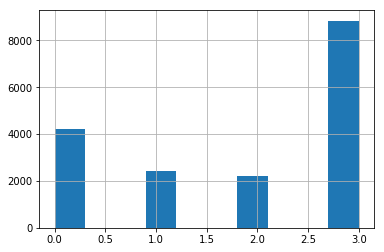

In [17]:
final_pred = run_lgb_regression(reduce_train, ajusted_test, features, 5)

In [18]:
#y_xgb_pred = run_xgb_regression(reduce_train, ajusted_test, features, 5)

In [19]:
'''
lgb_weight = 0.7
final_pred = y_lgb_pred * lgb_weight + y_xgb_pred * (1 - lgb_weight)
print(final_pred.shape, y_lgb_pred.shape, y_xgb_pred.shape)
'''

'\nlgb_weight = 0.7\nfinal_pred = y_lgb_pred * lgb_weight + y_xgb_pred * (1 - lgb_weight)\nprint(final_pred.shape, y_lgb_pred.shape, y_xgb_pred.shape)\n'

{0: 1.2941639230172615, 1: 1.7064724510377518, 2: 1.937088867112326}


3    0.500
0    0.239
1    0.136
2    0.125
Name: accuracy_group, dtype: float64

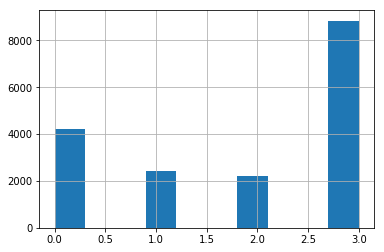

In [20]:
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
reduce_train['accuracy_group'].hist()

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(final_pred, acum * 100)
print(bound)

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, final_pred)))

sample_submission['accuracy_group'] = final_pred.astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission['accuracy_group'].value_counts(normalize=True)